# EDA + Data Cleansing

In [29]:
import os
import re
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle as pkl
import seaborn as sns
from impyute.imputation.cs import fast_knn
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from scipy import stats

# %matplotlib inline
warnings.filterwarnings('ignore')

# set sandbox_mode boolean for image building
* if sandbox_mode = True: faster to run, but images won't be generated

In [30]:
sandbox_mode = False

# define functions

In [31]:
def get_numerical_mask(df):
    type_mask = []
    for i in df.dtypes:
        if str(i).startswith('float') or str(i).startswith('int'): # or str(i).startswith('bool')
            type_mask.append(True)
        else: type_mask.append(False)
    num_cols = list(np.array(df.columns)[type_mask])
    other_cols = list(np.array(df.columns)[[not elem for elem in type_mask]])
    
    return num_cols, other_cols

### functions related to missing data

In [32]:
def get_missing(df):
    total = df.isnull().sum()
    percent = (df.isnull().sum()/df.isnull().count())
    missing_data = pd.concat([total, percent], axis=1, keys=['total', 'percent_missing'])
    missing_data['percent_missing'] = missing_data['percent_missing']
    missing_data['percent_missing'] = missing_data['percent_missing'].apply(lambda x: round(x,2))
    
    return missing_data

def drop_missing_from_threshold(df, row_threshold, col_threshold):
    row_count, col_count = df.shape
    # drop columns according to threshold of missing; use mask of columns which have less missing than threshold
    df = df.iloc[:, (df_missing['percent_missing'] < col_threshold).to_list()]
    
    # drop row according to threshold of missing
    n_cols = df.shape[1]
    df['ratio_mis'] = df.apply(lambda x: (n_cols - x.count())/n_cols, axis=1)
    df = df[df['ratio_mis']<row_threshold]
    df.drop(['ratio_mis'], axis=1, inplace=True)
    
    # count number of removals
    row_count_new, col_count_new = df.shape
    row_count_removal = row_count - row_count_new
    col_count_removal = col_count - col_count_new
    print('{} rows and {} columns were removed from database'.format(row_count_removal, col_count_removal))
    
    return df

def apply_imputation(df, method = 'knn', k=30, manual_val=-1):
    try:
        assert method in ['knn', 'mode', 'median', -1, 'manual']
    except AssertionError:
        raise ValueError('error: select a correct method for imputation: [knn, mode, median, -1, manual]')
        
    if method == 'knn':
        sys.setrecursionlimit(100000) #Increase the recursion limit of the OS
        numerical_cols, other_cols = get_numerical_mask(df)
        
#         df =  StandardScaler().fit_transform(df) # scale for knn to work properly (it's distance based)

        # start the KNN training
        imputed_training = fast_knn(df[numerical_cols], k=30)

        # retrieve column names
        imp_cols = imputed_training.columns.to_list()
        imputed_training.rename({imp_cols[i]: numerical_cols[i] for i in range(len(imp_cols))}, axis = 1, inplace=True)
        df.reset_index(inplace=True)
        other_cols.append('id')
        df = df[other_cols].merge(imputed_training, left_index=True, right_index=True)
        df.set_index('id', inplace=True)
        
    elif method == 'mode':
        df.fillna(data.mode().iloc[0], inplace=True)
        
    elif method == 'median':
        df.fillna(df.median(), inplace=True)

    elif method == -1:
        df.fillna(-1, inplace=True)
    
    elif method == 'manual':
        df.fillna(manual_val, inplace=True)
        
    try:
        assert df[df.isna().any(axis=1)].shape[0] == 0
    except AssertionError:
        raise ValueError('there are still missing values')
    
    return df

### functions related to outliers

In [33]:
def apply_standard_deviation_tol(df, tol=3):
    #scale data for operation
    df = pd.DataFrame(StandardScaler().fit_transform(df[numerical_cols]))
    
    z = np.abs(stats.zscore(df))
    z = pd.DataFrame(z, columns = df.columns, index=df.index)
    z.fillna(0, inplace=True)
    for col in z.columns[2:]:
        z = z[z[col]<tol]
    print("{0:.2%} of data was removed after dealing with outliers".format((df.shape[0]-z.shape[0])/df.shape[0]))
    df = df.loc[z.index, :]
    
    return df

def apply_isolation_forest(df, contamination=0.05):
    clf = IsolationForest(max_samples='auto', contamination=contamination, random_state=42) # contamination='auto' or 0.05
    clf.fit(df)

    outlier_pred = clf.predict(df)
    print('number of outliers:', np.count_nonzero(outlier_pred == -1), 'from a total of {}'.format(len(outlier_pred)))
    print('percentage of outliers: {0:.0%}'.format(np.count_nonzero(outlier_pred == -1)/np.count_nonzero(outlier_pred == 1)))
    
    return outlier_pred

def get_outliers(df, label, cols, method = 'isolation_forest', if_contamination = 0.05, z_tol = 3):

    if method == 'isolation_forest':
        outliers = apply_isolation_forest(df, if_contamination)
    elif method == 'standard_deviation_tol':
        df = apply_standard_deviation_tol(df, z_tol)
    
    print(len(outliers))
    return outliers, label

# Define paths and capture data

In [34]:
inputs = os.path.join('..', 'data', '02_intermediate')
outputs = os.path.join('..', 'data', '02_intermediate')
reports = os.path.join('..', 'data', '06_reporting')

In [35]:
data               = pd.read_csv(os.path.join(inputs, 'X_train.csv'), index_col='id')
data_test          = pd.read_csv(os.path.join(inputs, 'X_test.csv'), index_col='id')
y_train            = pd.read_csv(os.path.join(inputs, 'y_train.csv'), index_col='id')
y_test             = pd.read_csv(os.path.join(inputs, 'y_test.csv'), index_col='id')

In [36]:
print('Dataset dimensions:', data.shape)
data.head()

Dataset dimensions: (4930, 19)


,gender_male,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges
id,,,,,,,,,,,,,,,,,,,
7590-vhveg,0.0,0,1.0,0.0,1,0.0,no phone service,dsl,0.0,1.0,0.0,0.0,no,0.0,month-to-month,1.0,electronic check,29.85,29.85
5575-gnvde,1.0,0,0.0,0.0,34,1.0,no,dsl,1.0,0.0,1.0,0.0,no,0.0,one year,0.0,mailed check,56.95,1889.50
3668-qpybk,1.0,0,0.0,0.0,2,1.0,no,dsl,1.0,1.0,0.0,0.0,no,0.0,month-to-month,1.0,mailed check,53.85,108.15
7795-cfocw,1.0,0,0.0,0.0,45,0.0,no phone service,dsl,1.0,0.0,1.0,1.0,no,0.0,one year,0.0,bank transfer (automatic),42.30,1840.75
9237-hqitu,0.0,0,0.0,0.0,2,1.0,no,fiber optic,0.0,0.0,0.0,0.0,no,0.0,month-to-month,1.0,electronic check,70.70,151.65


# Checking  for possible anomalies in the database

In [37]:
data.describe()

,gender_male,seniorcitizen,partner,dependents,tenure,phoneservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingmovies,paperlessbilling,monthlycharges,totalcharges
count,4930.000000,4930.000000,4930.000000,4930.000000,4930.000000,4930.000000,3850.000000,3850.000000,3850.000000,3850.000000,3850.000000,4930.000000,4930.000000,4922.000000
mean,0.506897,0.159229,0.480933,0.296146,32.337120,0.908722,0.367792,0.441818,0.444416,0.367532,0.499481,0.588641,64.853824,2282.250772
std,0.500003,0.365927,0.499687,0.456603,24.633947,0.288033,0.482267,0.496668,0.496965,0.482196,0.500065,0.492130,30.140715,2270.485234
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,18.800000
25%,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35.512500,392.537500
50%,1.000000,0.000000,0.000000,0.000000,29.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,70.450000,1401.700000
75%,1.000000,0.000000,1.000000,1.000000,56.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,89.950000,3775.050000
max,1.000000,1.000000,1.000000,1.000000,72.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,118.750000,8684.800000


# missing data
usually, missing data is solved by filling it with some metric such as median. If the number of missing data in some entry is too high, we must evaluate for the removal of those entries.
For categorical with missing data, if you want to encode missing values, first change its type to a string:
```python
a[pd.isnull(a)]  = 'NaN'
```
Some refs:
* https://stackoverflow.com/questions/36808434/label-encoder-encoding-missing-values

About the missing values, we can't assume beforehand if those are Missing at Random (MAR) or Missing not at Random (MNAR). Further investigation would be necessary to properly decide over how to handle it.

For now, I am assuming they are Missing at Random. So I will remove some of them through a threshold, and apply imputation for the rest. By applying a proper imputation I observed a slight improvement over the score.

The catch is that applying imputation over euclidean distances can be extremely imprecise.

### drop columns and rows for threshold of missing

In [38]:
print('SORTED LIST OF MISSING VALUES')
df_missing = get_missing(data)
df_missing_vis = df_missing[df_missing['total'] > 0]
df_missing_vis['percent_missing'] = df_missing_vis['percent_missing'].apply(lambda x: round(x, 2))
# df_missing_vis.sort_values(by='percent_missing', ascending=False).head(20)
df_missing_vis.sort_values(by='percent_missing', ascending=False)

SORTED LIST OF MISSING VALUES


,total,percent_missing
onlinesecurity,1080,0.22
onlinebackup,1080,0.22
deviceprotection,1080,0.22
techsupport,1080,0.22
streamingmovies,1080,0.22
totalcharges,8,0.00


In [39]:
col_mis_threshold = 0.8
row_mis_threshold = 0.5

In [40]:
data = drop_missing_from_threshold(data, row_mis_threshold, col_mis_threshold)

0 rows and 0 columns were removed from database


### visualize rows with missing
we already know that the critical columns are related to geo_location

In [41]:
sandbox_mode = True
if sandbox_mode:
    print('number of missing:', data[data.isna().any(axis=1)].shape[0])
data[data.isna().any(axis=1)].tail()

number of missing: 1083


,gender_male,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges
id,,,,,,,,,,,,,,,,,,,
7161-dfhuf,0.0,0,1.0,0.0,71,1.0,yes,no,NaN,NaN,NaN,NaN,no internet service,NaN,two year,0.0,mailed check,23.85,1672.10
6040-cgacy,0.0,0,0.0,0.0,15,1.0,no,no,NaN,NaN,NaN,NaN,no internet service,NaN,month-to-month,0.0,mailed check,19.60,299.40
6582-plfuu,1.0,0,1.0,1.0,51,1.0,no,no,NaN,NaN,NaN,NaN,no internet service,NaN,two year,0.0,credit card (automatic),19.55,1086.75
0264-cnitk,0.0,0,1.0,1.0,71,1.0,no,no,NaN,NaN,NaN,NaN,no internet service,NaN,two year,0.0,bank transfer (automatic),20.10,1389.60
4774-hhggs,1.0,0,1.0,0.0,30,1.0,no,no,NaN,NaN,NaN,NaN,no internet service,NaN,two year,0.0,mailed check,19.05,637.55


### get types of columns

In [42]:
numerical_cols, other_cols = get_numerical_mask(data)

### imputation of missing values
For continuous values, I would prefer knn over median, but it depends on normalized dataset. Nevertheless, we don't have missing on continuous datasets, even though we could encode categorical data. But the encoding step wasn't organized to precede this notebook, so I will stick to 'mode', which imputes the most frequent value.

Some refs:
* https://jamesrledoux.com/code/imputation#:~:text=One%20approach%20to%20imputing%20categorical,given%20in%20Pandas'%20value_counts%20function.

the apply_imputation function accepts the following methods: knn, median, mode, or -1 (impute as category -1 [for categorical vars])

In [43]:
# imputation over numerical variables
data[numerical_cols] = data[numerical_cols].astype(float)
if data[numerical_cols].isnull().values.any():
    data[numerical_cols] = apply_imputation(data[numerical_cols], method = 'knn', k = 30)

# imputation over categorical variables
# if data[other_cols].isnull().values.any():
data[other_cols] = apply_imputation(data[other_cols], method = 'mode', k = 30)

# manual imputation on lag and forecast variables
# manual_cols = ['lag_1', 'lag_2', 'lag_3']
# if data[manual_cols].isnull().values.any():
#     data[manual_cols] = apply_imputation(data[manual_cols], method = 'manual', manual_val = False)
# data_test['y'].fillna(value=data_test['y'], inplace=True)

In [44]:
# imputation over numerical variables
data_test[numerical_cols] = data_test[numerical_cols].astype(float)
if data_test[numerical_cols].isnull().values.any():
    data_test[numerical_cols] = apply_imputation(data_test[numerical_cols], method = 'knn', k = 30)

# imputation over categorical variables
if data_test[other_cols].isnull().values.any():
    data_test[other_cols] = apply_imputation(data_test[other_cols], method = 'mode', k = 30)

# anomaly detection
remove outliers from choosing one of the following methods: isolation_forest, standard_deviation_tol (using z_score on standardized version)

other parameters are:
* if_contamination: isolation forest level of contamination
* z_tol: tolerance for standard deviation (if using zscore)

It is not advisable to remove outliers without proper consideration.

Some interesting refs:
* https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba
* https://towardsdatascience.com/anomaly-detection-with-isolation-forest-visualization-23cd75c281e2
* https://towardsdatascience.com/outlier-detection-with-isolation-forest-3d190448d45e

In [45]:
# temporarily add train to test data (no leakage here)
test_start = data_test.index[0]
data_test = data.append(data_test)

# get outliers on train data
data['if_anomaly'], _ = get_outliers(data[numerical_cols], y_train, numerical_cols, 
                                                  method = 'isolation_forest', if_contamination = 0.05)

# get outliers on test data (needs trainset)

data_test['if_anomaly'], _ = get_outliers(data_test[numerical_cols], y_train, numerical_cols, 
                                                  method = 'isolation_forest', if_contamination = 0.05)

# removes trainset again
data_test = data_test.iloc[len(data):,:]

number of outliers: 247 from a total of 4930
percentage of outliers: 5%
4930
number of outliers: 353 from a total of 7043
percentage of outliers: 5%
7043


outlier removal isn't justified for now

In [46]:
remove_outliers = False

In [47]:
if remove_outliers:
    data = data[data['if_anomaly'] == 1]
    y_train = y_train[y_train.index.isin(data.index.to_list())]

In [48]:
data_test

,gender_male,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,if_anomaly
id,,,,,,,,,,,,,,,,,,,,
8180-akmjv,0.0,0.0,0.0,0.0,1.0,1.0,no,dsl,0.0,0.0,0.0,0.0,no,0.0,month-to-month,1.0,credit card (automatic),44.55,44.55,1
4298-oyifc,1.0,0.0,1.0,0.0,15.0,1.0,yes,fiber optic,0.0,0.0,1.0,1.0,yes,1.0,month-to-month,1.0,electronic check,103.45,1539.80,1
5566-soezd,1.0,0.0,1.0,1.0,27.0,1.0,no,fiber optic,1.0,1.0,0.0,0.0,no,0.0,one year,1.0,credit card (automatic),80.65,2209.75,1
9842-efsyy,0.0,0.0,0.0,1.0,4.0,0.0,no phone service,dsl,1.0,1.0,1.0,0.0,yes,1.0,month-to-month,1.0,mailed check,57.20,223.75,-1
2272-wuspa,0.0,0.0,1.0,0.0,72.0,1.0,yes,fiber optic,1.0,1.0,1.0,0.0,yes,1.0,two year,1.0,electronic check,110.75,7751.70,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-resvb,1.0,0.0,1.0,1.0,24.0,1.0,yes,dsl,1.0,0.0,1.0,1.0,yes,1.0,one year,1.0,mailed check,84.80,1990.50,1
2234-xaduh,0.0,0.0,1.0,1.0,72.0,1.0,yes,fiber optic,0.0,1.0,1.0,0.0,yes,1.0,one year,1.0,credit card (automatic),103.20,7362.90,1
4801-jzazl,0.0,0.0,1.0,1.0,11.0,0.0,no phone service,dsl,1.0,0.0,0.0,0.0,no,0.0,month-to-month,1.0,electronic check,29.60,346.45,1


# drop redundant features

# build new variables

# Visualize pairwise relations
When datasets have just a few variables (10–15), pairplots allow for a quick visual inspection of those relations, as well as bariable distributions.

In [49]:
numerical_cols, other_cols = get_numerical_mask(data)

In [50]:
separator = int(len(numerical_cols)/2)

#### group 1

In [51]:
if not sandbox_mode:
    data_vis = data[numerical_cols[:separator]]
    data_vis['y'] = y_train['y']
    print('visualize pairplots')
    sns.pairplot(data_vis, plot_kws={'alpha': 0.1});
    plt.savefig(os.path.join(reports,'01_pairplots_1.jpg'), bbox_inches = "tight")

#### group 2

In [52]:
if not sandbox_mode:
    data_vis = data[numerical_cols[separator:]]
    data_vis['y'] = y_train['y']
    print('visualize pairplots')
    sns.pairplot(data_vis, plot_kws={'alpha': 0.1});
    plt.savefig(os.path.join(reports,'01_pairplots_2.jpg'), bbox_inches = "tight")

# Check if data is imbalanced
When data is imbalanced, we must evaluate for solutions such as oversampling or undersamplig, which might be done with techniques such as SMOTE (Synthetic Minority Oversampling Technique).

In [53]:
y = y_train.append(y_test)

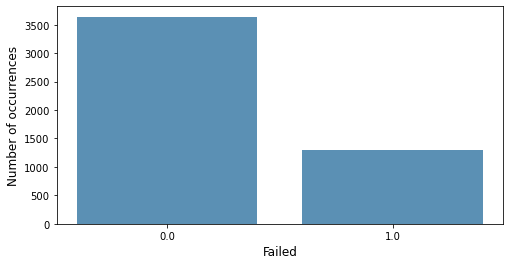

In [55]:
color = sns.color_palette()
classif = y_train['y'].value_counts()
plt.figure(figsize=(8,4))
sns.barplot(classif.index, classif.values, alpha=0.8, color=color[0])
plt.ylabel('Number of occurrences', fontsize=12)
plt.xlabel('Failed', fontsize=12)
plt.plot()
plt.savefig(os.path.join(reports,'imbalance.jpg'), bbox_inches = "tight")

In [56]:
counts = y['y'].value_counts()
counts

0.0    5174
1.0    1869
Name: y, dtype: int64

In [57]:
print('ratio between classes:',round(counts[0]/counts[1],2))
print('\r\nCheck proportions below:')
y['y'].value_counts(normalize=True)

ratio between classes: 2.77

Check proportions below:


0.0    0.73463
1.0    0.26537
Name: y, dtype: float64

# Description (2nd round)

In [58]:
if sandbox_mode:
    print(data.shape[0])
    print(y_train.shape[0])
    print(data_test.shape[0])
    print(y_test.shape[0])
    data.describe()

4930
4930
2113
2113


# save intermediate data

In [59]:
data.to_csv(os.path.join(outputs, 'X_train.csv'))
data_test.to_csv(os.path.join(outputs, 'X_test.csv'))

y_train.to_csv(os.path.join(outputs, 'y_train.csv'))
y_test.to_csv(os.path.join(outputs, 'y_test.csv'))